# Weight Decay

In the previous section, we encountered overfitting and the need for capacity control. While increasing the training data set may mitigate overfitting, obtaining additional training data is often costly, hence it is preferable to control the complexity of the functions we use. In particular, we saw that we could control the complexity of a polynomial by adjusting its degree. While this might be a fine strategy for problems on one-dimensional data, this quickly becomes difficult to manage and too coarse. For instance, for vectors of dimensionality $D$ the number of monomials of a given degree $d$ is ${D -1 + d} \choose {D-1}$. Hence, instead of controlling for the number of functions we need a more fine-grained tool for adjusting function complexity.

## Squared Norm Regularization

One of the most commonly used techniques is weight decay. It relies on the notion that among all functions $f$ the function $f = 0$ is the simplest of all. Hence we can measure functions by their proximity to zero. There are many ways of doing this. In fact there exist entire branches of mathematics, e.g. in functional analysis and the theory of Banach spaces which are devoted to answering this issue.

For our purpose something much simpler will suffice:
A linear function $f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x}$ can be considered simple if its weight vector is small. We can measure this via $\|\mathbf{w}\|^2$. One way of keeping the weight vector small is to add its value as a penalty to the problem of minimizing the loss. This way if the weight vector becomes too large, the learning algorithm will prioritize minimizing $\mathbf{w}$ over minimizing the training error. That's exactly what we want. To illustrate things in code, consider the previous section on [“Linear Regression”](linear-regression.md). There the loss is given by

$$l(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

Recall that $\mathbf{x}^{(i)}$ are the observations, $y^{(i)}$ are labels, and $(\mathbf{w}, b)$ are the weight and bias parameters respectively. To arrive at the new loss function which penalizes the size of the weight vector we need to add $\|\mathbf{w}\|^2$, but how much should we add? This is where the regularization constant (hyperparameter) $\lambda$ comes in:

$$l(\mathbf{w}, b) + \frac{\lambda}{2} \|\boldsymbol{w}\|^2$$

$\lambda \geq 0$ governs the amount of regularization. For $\lambda = 0$ we recover the previous loss function, whereas for $\lambda > 0$ we ensure that $\mathbf{w}$ cannot grow too large. The astute reader might wonder why we are squaring the weight vector. This is done both for computational convenience since it leads to easy to compute derivatives, and for statistical performance, as it penalizes large weight vectors a lot more than small ones. The stochastic gradient descent updates look as follows:

$$
\begin{aligned}
w & \leftarrow \left(1- \frac{\eta\lambda}{|\mathcal{B}|} \right) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right),
\end{aligned}
$$

As before, we update $\mathbf{w}$ in accordance to the amount to which our estimate differs from the observation. However, we also shrink the size of $\mathbf{w}$ towards $0$, i.e. the weight 'decays'. This is much more convenient than having to pick the number of parameters as we did for polynomials. In particular, we now have a continuous mechanism for adjusting the complexity of $f$. Small values of $\lambda$ correspond to fairly unconstrained $\mathbf{w}$ whereas large values of $\lambda$ constrain $\mathbf{w}$ considerably. Since we don't want to have large bias terms either, we often add $b^2$ as penalty, too.

## High-dimensional Linear Regression

For high-dimensional regression it is difficult to pick the 'right' dimensions to omit. Weight-decay regularization is a much more convenient alternative. We will illustrate this below. But first we need to generate some data via

$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01)$$

That is, we have additive Gaussian noise with zero mean and variance 0.01. In order to observe overfitting more easily we pick a high-dimensional problem with $d = 200$ and a deliberatly low number of training examples, e.g. 20. As before we begin with our import ritual (and data generation).

In [1]:
%matplotlib inline
import gluonbook as gb
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = nd.ones((num_inputs, 1)) * 0.01, 0.05

features = nd.random.normal(shape=(n_train + n_test, num_inputs))
labels = nd.dot(features, true_w) + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

## Weight Decay from Scratch

Next, we will show how to implement weight decay from scratch. For this we simply add the $\ell_2$ penalty as an additional loss term after the target function. The squared norm penalty derives its name from the fact that we are adding the second power $\sum_i x_i^2$. There are many other related penalties. In particular, the $\ell_p$ norm is defined as

$$\|\mathbf{x}\|_p^p := \sum_{i=1}^d |x_i|^p$$

### Initialize Model Parameters

First, define a function that randomly initializes model parameters. This function attaches a gradient to each parameter.

In [2]:
def init_params():
    w = nd.random.normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    w.attach_grad()
    b.attach_grad()
    return [w, b]

### Define $\ell_2$ Norm Penalty

A convenient way of defining this penalty is by squaring all terms in place and summing them up. We divide by $2$ to keep the math looking nice and simple.

In [3]:
def l2_penalty(w):
    return (w**2).sum() / 2

### Define Training and Testing

The following defines how to train and test the model separately on the training data set and the test data set. Unlike the previous sections, here, the $\ell_2$ norm penalty term is added when calculating the final loss function. The linear network and the squared loss are as before and thus imported via `gb.linreg` and `gb.squared_loss` respectively.

In [4]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = gb.linreg, gb.squared_loss
train_iter = gdata.DataLoader(gdata.ArrayDataset(
    train_features, train_labels), batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                # The L2 norm penalty term has been added.
                l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l.backward()
            gb.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b),
                             train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features, w, b),
                            test_labels).mean().asscalar())
    gb.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('l2 norm of w:', w.norm().asscalar())

### Training without Regularization

Next, let's train and test the high-dimensional linear regression model. When `lambd = 0` we do not use weight decay. As a result, while the training error decreases, the test error does not. This is a perfect example of overfitting.

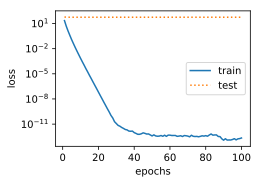

l2 norm of w: 11.611942


In [5]:
fit_and_plot(lambd=0)

### Using Weight Decay

The example below shows that even though the training error increased, the error on the test set decreased. This is precisely the improvement that we expect from using weight decay. While not perfect, overfitting has been mitigated to some extent. In addition, the $\ell_2$ norm of the weight $\mathbf{w}$ is smaller than without using weight decay.

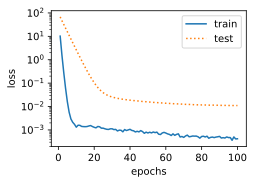

l2 norm of w: 0.04164811


In [6]:
fit_and_plot(lambd=3)

## Weight Decay in Gluon

Weight decay in Gluon is quite convenient (and also a bit special) insofar as it is typically integrated with the optimization algorithm itself. The reason for this is that it is much faster (in terms of runtime) for the optimizer to take care of weight decay and related things right inside the optimization algorithm itself, since the optimizer itself needs to touch all parameters anyway.

Here, we directly specify the weight decay hyper-parameter through the `wd` parameter when constructing the `Trainer` instance. By default, Gluon decays weight and bias simultaneously. Note that we can have *different* optimizers for different sets of parameters. For instance, we can have a `Trainer` with weight decay and one without to take care of $\mathbf{w}$ and $b$ respectively.

In [7]:
def fit_and_plot_gluon(wd):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    # The weight parameter has been decayed. Weight names generally end with "weight".
    trainer_w = gluon.Trainer(net.collect_params('.*weight'), 'sgd',
                              {'learning_rate': lr, 'wd': wd})
    # The bias parameter has not decayed. Bias names generally end with "bias".
    trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd',
                              {'learning_rate': lr})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            # Call the step function on each of the two Trainer instances to update the weight and bias separately.
            trainer_w.step(batch_size)
            trainer_b.step(batch_size)
        train_ls.append(loss(net(train_features),
                             train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features),
                            test_labels).mean().asscalar())
    gb.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net[0].weight.data().norm().asscalar())

The plots look just the same as when we implemented weight decay from scratch (but they run a bit faster and are a bit easier to implement, in particular for large problems).

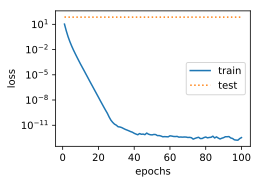

L2 norm of w: 13.311797


In [8]:
fit_and_plot_gluon(0)

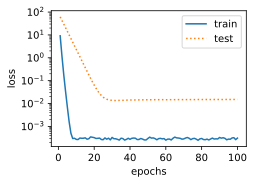

L2 norm of w: 0.03246026


In [9]:
fit_and_plot_gluon(3)

So far we only touched upon what constitutes a simple *linear* function. For nonlinear functions answering this question is way more complex. For instance, there exist [Reproducing Kernel Hilbert Spaces](https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space) which allow one to use many of the tools introduced for linear functions in a nonlinear context. Unfortunately, algorithms using them do not always scale well to very large amounts of data. For all intents and purposes of this book we limit ourselves to simply summing over the weights for different layers, e.g. via $\sum_l \|\mathbf{w}_l\|^2$, which is equivalent to weight decay applied to all layers.


## Summary

* Regularization is a common method for dealing with overfitting. It adds a penalty term to the loss function on the training set to reduce the complexity of the learned model.
* One particular choice for keeping the model simple is weight decay using an $\ell_2$ penalty. This leads to weight decay in the update steps of the learning algorithm.
* Gluon provides automatic weight decay functionality in the optimizer by setting the hyperparameter `wd`.
* You can have different optimizers within the same training loop, e.g. for different sets of parameters.


## Problems

1. Experiment with the value of $\lambda$ in the estimation problem in this page. Plot training and test accuracy as a function of $\lambda$. What do you observe?
1. Use a validation set to find the optimal value of $\lambda$. Is it really the optimal value? Does this matter?
1. What would the update equations look like if instead of $\|\mathbf{w}\|^2$ we used $\sum_i |w_i|$ as our penalty of choice (this is called $\ell_1$ regularization).
1. We know that $\|\mathbf{w}\|^2 = \mathbf{w}^\top \mathbf{w}$. Can you find a similar equation for matrices (mathematicians call this the [Frobenius norm](https://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm))?
1. Review the relationship between training error and generalization error. In addition to weight decay, increased training, and the use of a model of suitable complexity, what other ways can you think of to deal with overfitting?
1. In Bayesian statistics we use the product of prior and likelihood to arrive at a posterior via $p(w|x) \propto p(x|w) p(w)$. How can you identify $p(w)$ with regularization?

## Discuss on our Forum

<div id="discuss" topic_id="2342"></div>